In [1]:
# 卷积网络的训练数据为MNIST(28*28灰度单色图像)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [2]:
train_epochs = 100    # 训练轮数
batch_size   = 100     # 随机出去数据大小
display_step = 1       # 显示训练结果的间隔
learning_rate= 0.0001  # 学习效率
drop_prob    = 0.5     # 正则化,丢弃比例
fch_nodes    = 512     # 全连接隐藏层神经元的个数


In [3]:
# 网络模型需要的一些辅助函数
# 权重初始化(卷积核初始化)
# tf.truncated_normal()不同于tf.random_normal(),返回的值中不会偏离均值两倍的标准差
# 参数shpae为一个列表对象,例如[5, 5, 1, 32]对应
# 5,5 表示卷积核的大小, 1代表通道channel,对彩色图片做卷积是3,单色灰度为
# 最后一个数字32,卷积核的个数,(也就是卷基层提取的特征数量)
#   显式声明数据类型,切记
def weight_init(shape):
    weights = tf.truncated_normal(shape, stddev=0.1,dtype=tf.float32)
    return tf.Variable(weights)

# 偏置的初始化
def biases_init(shape):
    biases = tf.random_normal(shape,dtype=tf.float32)
    return tf.Variable(biases)

# 随机选取mini_batch
def get_random_batchdata(n_samples, batchsize):
    start_index = np.random.randint(0, n_samples - batchsize)
    return (start_index, start_index + batchsize)

In [4]:
# 全连接层权重初始化函数xavier
def xavier_init(layer1, layer2, constant = 1):
    Min = -constant * np.sqrt(6.0 / (layer1 + layer2))
    Max = constant * np.sqrt(6.0 / (layer1 + layer2))
    return tf.Variable(tf.random_uniform((layer1, layer2), minval = Min, maxval = Max, dtype = tf.float32))

In [5]:
# 卷积
def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')

# 源码的位置在tensorflow/python/ops下nn_impl.py和nn_ops.py
# 这个函数接收两个参数,x 是图像的像素, w 是卷积核
# x 张量的维度[batch, height, width, channels]
# w 卷积核的维度[height, width, channels, channels_multiplier]
# tf.nn.conv2d()是一个二维卷积函数,
# stirdes 是卷积核移动的步长,4个1表示,在x张量维度的四个参数上移动步长
# padding 参数'SAME',表示对原始输入像素进行填充,卷积后映射的2D图像与原图大小相等
# 填充,是指在原图像素值矩阵周围填充0像素点
# 如果不进行填充,假设 原图为 32x32 的图像,卷积和大小为 5x5 ,卷积后映射图像大小 为 28x28

In [6]:
# 池化
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# 池化跟卷积的情况有点类似
# x 是卷积后,有经过非线性激活后的图像,
# ksize 是池化滑动张量
# ksize 的维度[batch, height, width, channels],跟 x 张量相同
# strides [1, 2, 2, 1],与上面对应维度的移动步长
# padding与卷积函数相同,padding='VALID',对原图像不进行0填充

In [7]:
# x 是手写图像的像素值,y 是图像对应的标签
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
# 把灰度图像一维向量,转换为28x28二维结构
x_image = tf.reshape(x, [-1, 28, 28, 1])
# -1表示任意数量的样本数,大小为28x28深度为一的张量
# 可以忽略(其实是用深度为28的,28x1的张量,来表示28x28深度为1的张量)

In [8]:
#第一层卷积+池化

w_conv1 = weight_init([5, 5, 1, 16])                             # 5x5,深度为1,16个
b_conv1 = biases_init([16])
h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)    # 输出张量的尺寸:28x28x16
h_pool1 = max_pool_2x2(h_conv1)                                   # 池化后张量尺寸:14x14x16
# h_pool1 , 14x14的16个特征图

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
#第二层卷积+池化
w_conv2 = weight_init([5, 5, 16, 32])                             # 5x5,深度为16,32个
b_conv2 = biases_init([32])
h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)    # 输出张量的尺寸:14x14x32
h_pool2 = max_pool_2x2(h_conv2)                                   # 池化后张量尺寸:7x7x32
# h_pool2 , 7x7的32个特征图

In [10]:
#全连接层
# h_pool2是一个7x7x32的tensor,将其转换为一个一维的向量
h_fpool2 = tf.reshape(h_pool2, [-1, 7*7*32])
# 全连接层,隐藏层节点为512个
# 权重初始化
w_fc1 = xavier_init(7*7*32, fch_nodes)
b_fc1 = biases_init([fch_nodes])
h_fc1 = tf.nn.relu(tf.matmul(h_fpool2, w_fc1) + b_fc1)

In [11]:
# 全连接隐藏层/输出层
# 为了防止网络出现过拟合的情况,对全连接隐藏层进行 Dropout(正则化)处理,在训练过程中随机的丢弃部分
# 节点的数据来防止过拟合.Dropout同把节点数据设置为0来丢弃一些特征值,仅在训练过程中,
# 预测的时候,仍使用全数据特征
# 传入丢弃节点数据的比例
#keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob=drop_prob)

# 隐藏层与输出层权重初始化
w_fc2 = xavier_init(fch_nodes, 10)
b_fc2 = biases_init([10])

# 未激活的输出
y_ = tf.add(tf.matmul(h_fc1_drop, w_fc2), b_fc2)
# 激活后的输出
y_out = tf.nn.softmax(y_)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# 交叉熵代价函数
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_out), reduction_indices = [1]))

# tensorflow自带一个计算交叉熵的方法
# 输入没有进行非线性激活的输出值 和 对应真实标签
#cross_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_, y))

# 优化器选择Adam(有多个选择)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# 准确率
# 每个样本的预测结果是一个(1,10)的vector
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_out, 1))
# tf.cast把bool值转换为浮点数
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use tf.cast instead.


In [13]:
# 全局变量进行初始化的Operation
init = tf.global_variables_initializer()

In [14]:
# 加载数据集MNIST
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
n_samples = int(mnist.train.num_examples)
total_batches = int(n_samples / batch_size)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Epoch : 1 ,  Cost : 1.8774227
Epoch : 2 ,  Cost : 1.2439001
Epoch : 3 ,  Cost : 0.9896900
Epoch : 4 ,  Cost : 0.6396503
Epoch : 5 ,  Cost : 0.3547547
Epoch : 6 ,  Cost : 0.2489945
Epoch : 7 ,  Cost : 0.4923461
Epoch : 8 ,  Cost : 0.1659002
Epoch : 9 ,  Cost : 0.2349122
Epoch : 10 ,  Cost : 0.1365998
Epoch : 11 ,  Cost : 0.1129940
Epoch : 12 ,  Cost : 0.1323991
Epoch : 13 ,  Cost : 0.1939042
Epoch : 14 ,  Cost : 0.0976349
Epoch : 15 ,  Cost : 0.1499611
Epoch : 16 ,  Cost : 0.0870827
Epoch : 17 ,  Cost : 0.1848018
Epoch : 18 ,  Cost : 0.1723011
Epoch : 19 ,  Cost : 0.1839711
Epoch : 20 ,  Cost : 0.1228178
Epoch : 21 ,  Cost : 0.2508216
Epoch : 22 ,  Cost : 0.0865927
Epoch : 23 ,  Cost : 0.1293168
Epoch : 24 ,  Cost : 0.0738546
Epoch : 25 ,  Cost : 0.0792958
Epoch : 26 ,  Cost : 0.2228885
Epoch : 27 ,  Cost : 0.0634577
Epoch : 28 ,  Cost : 0.0756350
Epoch : 29 ,  Cost : 0.1914489
Epoch : 30 ,  Cost : 0.0576199
Epoch : 31 ,  Cost : 0.0429372
Epoch : 32 ,  Cost : 0.1714942
Epoch : 33 ,  Cos

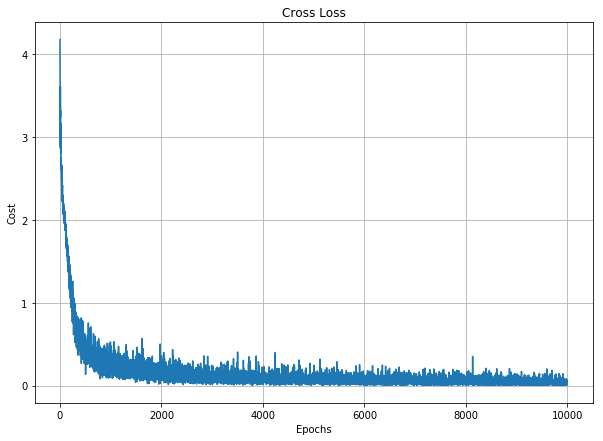

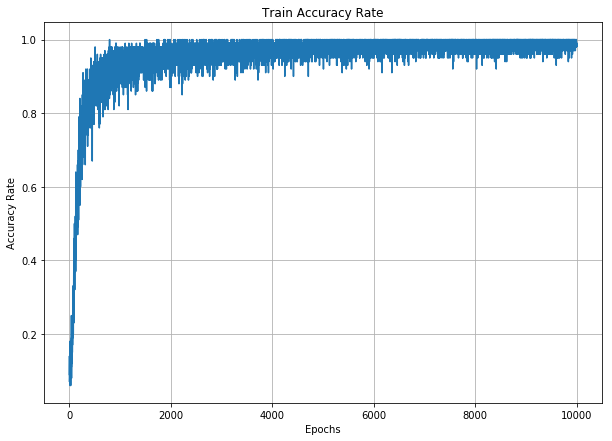

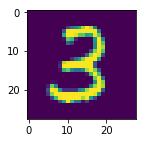

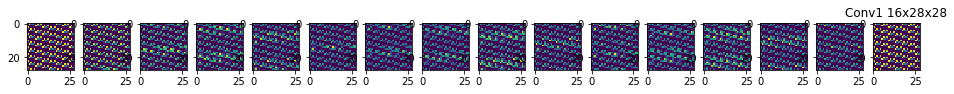

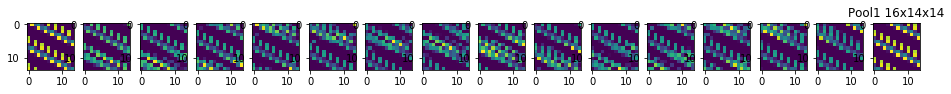

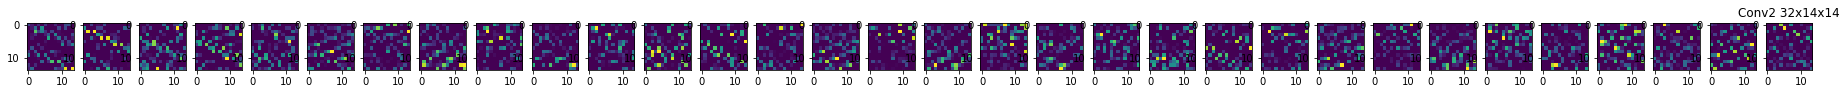

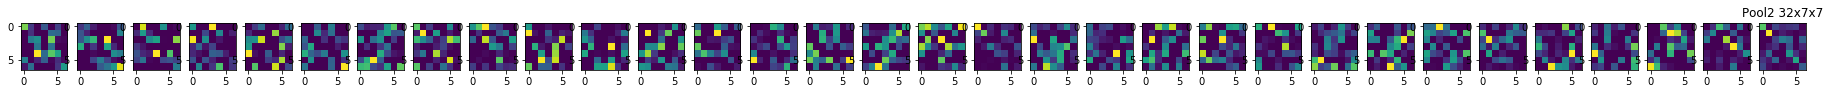

In [15]:
# 会话
with tf.Session() as sess:
    sess.run(init)
    Cost = []
    Accuracy = []
    for i in range(train_epochs):

        for j in range(100):
            start_index, end_index = get_random_batchdata(n_samples, batch_size)

            batch_x = mnist.train.images[start_index: end_index]
            batch_y = mnist.train.labels[start_index: end_index]
            _, cost, accu = sess.run([ optimizer, cross_entropy,accuracy], feed_dict={x:batch_x, y:batch_y})
            Cost.append(cost)
            Accuracy.append(accu)
        if i % display_step ==0:
            print ('Epoch : %d ,  Cost : %.7f'%(i+1, cost))
    print 'training finished'
    # 代价函数曲线
    fig1,ax1 = plt.subplots(figsize=(10,7))
    plt.plot(Cost)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cost')
    plt.title('Cross Loss')
    plt.grid()
    plt.show()
    # 准确率曲线
    fig7,ax7 = plt.subplots(figsize=(10,7))
    plt.plot(Accuracy)
    ax7.set_xlabel('Epochs')
    ax7.set_ylabel('Accuracy Rate')
    plt.title('Train Accuracy Rate')
    plt.grid()
    plt.show()
#----------------------------------各个层特征可视化-------------------------------
    # imput image
    fig2,ax2 = plt.subplots(figsize=(2,2))
    ax2.imshow(np.reshape(mnist.train.images[11], (28, 28)))
    plt.show()

    # 第一层的卷积输出的特征图
    input_image = mnist.train.images[11:12]
    conv1_16 = sess.run(h_conv1, feed_dict={x:input_image})     # [16, 28, 28 ,1] 
    conv1_reshape = sess.run(tf.reshape(conv1_16, [16, 1, 28, 28]))
    fig3,ax3 = plt.subplots(nrows=1, ncols=16, figsize = (16,1))
    for i in range(16):
        ax3[i].imshow(conv1_reshape[i][0])                      # tensor的切片[batch, channels, row, column]

    plt.title('Conv1 16x28x28')
    plt.show()

    # 第一层池化后的特征图
    pool1_16 = sess.run(h_pool1, feed_dict={x:input_image})     # [16, 14, 14, 1]
    pool1_reshape = sess.run(tf.reshape(pool1_16, [16, 1, 14, 14]))
    fig4,ax4 = plt.subplots(nrows=1, ncols=16, figsize=(16,1))
    for i in range(16):
        ax4[i].imshow(pool1_reshape[i][0])

    plt.title('Pool1 16x14x14')
    plt.show()

    # 第二层卷积输出特征图
    conv2_32 = sess.run(h_conv2, feed_dict={x:input_image})          # [32, 14, 14, 1]
    conv2_reshape = sess.run(tf.reshape(conv2_32, [32, 1, 14, 14]))
    fig5,ax5 = plt.subplots(nrows=1, ncols=32, figsize = (32, 1))
    for i in range(32):
        ax5[i].imshow(conv2_reshape[i][0])
    plt.title('Conv2 32x14x14')
    plt.show()

    # 第二层池化后的特征图
    pool2_32 = sess.run(h_pool2, feed_dict={x:input_image})          #[32, 7, 7, 1]
    pool2_reshape = sess.run(tf.reshape(pool2_32, [32, 1, 7, 7]))
    fig6,ax6 = plt.subplots(nrows=1, ncols=32, figsize = (32, 1))
    plt.title('Pool2 32x7x7')
    for i in range(32):
        ax6[i].imshow(pool2_reshape[i][0])

    plt.show()